# PW11 - Deep Q-Network
Objective: write the DQN algorithm and apply the corresponding policy to an [environment](https://gym.openai.com/envs/#classic_control) provided by Gym. In the following, we choose the CartPole environment, but feel free to change.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
PATH_TO_ROOT = "/content/drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/11-value/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import random

To render gym environment into colab

In [5]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip3 install xvfbwrapper
!pip3 install gym pyvirtualdisplay > /dev/null 2>&1

In [6]:
# Display
from pyvirtualdisplay import Display
from IPython import display

d = Display()
d.start() 

## Description of the problem

In [7]:
# Load the environment
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) 

[50]

A pole is attached by an joint to a cart, moving along a frictionless track. 

The continuous state space $S$ is  a 4-D dimensional space, composed of:
- an $x$ coordinate for location, in [-4.8,4.8], 
- the velocity of the cart in $\mathbb{R}$, 
- the angle of the pole in [-24,24],
- the velocity at the tip of the pole in $\mathbb{R}$. 

The action space is of size 2: applying a force of +1 or -1 to the cart (the actions)

The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

We assume that we have achieved our goal if the average of the total reward is greater than 195 for 5 consecutive episodes (just for time purposes)


## How does the system behave with a random agent ?
 

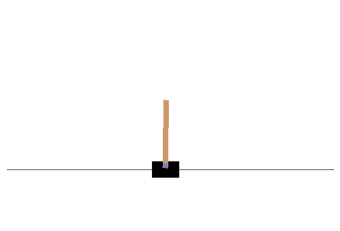

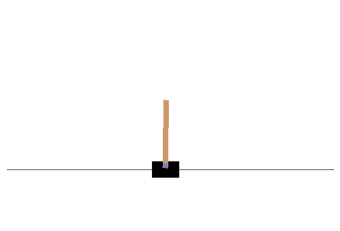

In [8]:
o = envCartPole.reset()
img = plt.imshow(envCartPole.render('rgb_array'))
for t in range(100):
  display.clear_output(wait=True)
  img.set_data(envCartPole.render('rgb_array'))
  plt.axis('off')
  display.display(plt.gcf())  
  a = envCartPole.action_space.sample()
  o,r,done,info = envCartPole.step(a)

  if done:
    o = envCartPole.reset()
envCartPole.close()

## Learning parameters

In [9]:
# Parameters
nb_episodes = 200
nb_end_training = 0
limit_time = 200

discount_rate = 0.90 #discount factor
batch_size = 40 # batch size for episode replay

In [10]:
#Success parameters
reward_threshold = 200
consecutive_wins = 10

## DQN Class  
Creates a DQN object with the following methods:

- init: initilization of the model parameters
- build_model : build the neural network approximating $Q$
- action: generates the action.  using either exploration ($\epsilon$-greedy) or exploitation (generation using the network)
- test_action: generate the action in the test phase (only exploitation)
- save_o: save the observables 
- experience_replay: use experience replay strategy to predict the optimal action with the network using a batch os samples in the memory 
  

In [11]:
class DQN():
    def __init__(self, states, actions, gamma, epsilon=1,epsilon_min=0.001, epsilon_decay=0.999):
        self.nb_states = states
        self.nb_actions = actions
        self.memory = deque([], maxlen=2500) # double-ended queue to manage the memory for the experience replay
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        
    # Build the neural network. Try this architecture
    # MLP: Dense(30,ReLU),Dense(30,ReLU),Dense(nb_actions) with MSE loss and Adam optimizer
    def build_model(self):
        #TODO
        model = Sequential()

        model.add(Dense(16,activation="relu"))
        model.add(Dense(32,activation="relu"))
        model.add(Dense(32,activation="relu"))
        model.add(Dense(self.nb_actions,activation="relu"))

        model.compile(loss="mse", optimizer="adam",metrics=['accuracy'])

        return model

    def action(self, state):
        # Draw an random number r: if r<epsilon, then explore the possible actions (draw a random action)
        # otherwise use the model to predict the best action (exploitation)

        #TODO
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nb_actions) #Explore
        a = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        a = np.argmax(a[0])
        return a

    def test_action(self, state): 
        #Only use the model to predict the best action to do

        #TODO
        a = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        a = np.argmax(a[0])
        return a

    def save_o(self, state, action, reward, nstate, done):
        #Store the experience in memory for experience replay
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #sample from memory
        minibatch = random.sample( self.memory, batch_size ) 

        #Vectorization (increase in speed)
        x = []
        y = []
        np_array = np.array(minibatch)
        s = np.zeros((0,self.nb_states)) 
        new_s = np.zeros( (0,self.nb_states))
        for i in range(len(np_array)): 
            s = np.append( s, np_array[i,0], axis=0) #states
            new_s = np.append( new_s, np_array[i,3], axis=0) # next states
        s_predict = self.model.predict(s) 
        new_s_predict = self.model.predict(new_s)
        i = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            new_s_action_predict_model = new_s_predict[i]
  
            target = reward + int(done==False)*(self.gamma * np.amax(new_s_action_predict_model))
            target_f = s_predict[i]
            target_f[action] = target
            y.append(target_f)
            i += 1
        
        x = np.array(x).reshape(batch_size,self.nb_states)
        y = np.array(y)
        epoch_count = 1 
        hist = self.model.fit(x, y, epochs=epoch_count, verbose=0)
        
        for e in range(epoch_count):
            self.loss.append( hist.history['loss'][e] )
        #Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [12]:
#Agent
nb_states = envCartPole.observation_space.shape[0] 
nb_actions = envCartPole.action_space.n 
dqn = DQN(nb_states, nb_actions, discount_rate)

In [13]:
#Training
rewards = [] 
epsilons = [] 
nb_test_episodes = 0
for e in range(nb_episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nb_states]) 

    tot_rewards = 0
    for time in range(limit_time): 
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nb_states])
        tot_rewards += reward
        dqn.save_o(state, action, reward, nstate, done) 
        
        state = nstate
        #time = limit_time-1: CartPole stayed upright
        #done: CartPole fell. 
        if done or time == limit_time-1:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, nb_episodes, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #Test if success : there must be at least `consecutive_wins`rewards greater than `reward_threshold'
    if len(rewards) > consecutive_wins and np.average(rewards[-5:]) > reward_threshold:
        #the nb_episodes remaining are dedicated to test
        nb_test_episodes = nb_episodes - e
        nb_end_training = e
        break

episode: 0/200, score: 13.0, e: 1
episode: 1/200, score: 15.0, e: 1
episode: 2/200, score: 9.0, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


episode: 3/200, score: 17.0, e: 0.9870777147137147
episode: 4/200, score: 11.0, e: 0.9772512378214517
episode: 5/200, score: 12.0, e: 0.9665550620990835
episode: 6/200, score: 13.0, e: 0.9550199818235596
episode: 7/200, score: 39.0, e: 0.9193926150309796
episode: 8/200, score: 48.0, e: 0.8771602801771059
episode: 9/200, score: 12.0, e: 0.8675596164681794
episode: 10/200, score: 9.0, e: 0.8606433826830369
episode: 11/200, score: 40.0, e: 0.8277082323811443
episode: 12/200, score: 24.0, e: 0.8088788946494789
episode: 13/200, score: 9.0, e: 0.8024304668606914
episode: 14/200, score: 22.0, e: 0.7857468750083979
episode: 15/200, score: 11.0, e: 0.7779246707428734
episode: 16/200, score: 10.0, e: 0.7709512887465825
episode: 17/200, score: 9.0, e: 0.764805221953346
episode: 18/200, score: 13.0, e: 0.7556778685553796
episode: 19/200, score: 11.0, e: 0.7481550048510686
episode: 20/200, score: 29.0, e: 0.7274870315965022
episode: 21/200, score: 23.0, e: 0.7116492513781133
episode: 22/200, score:

In [14]:
dqn.model.save(PATH_TO_ROOT + 'dqn.h5')
#Once trained...
dqn.model = load_model(PATH_TO_ROOT + 'dqn.h5')

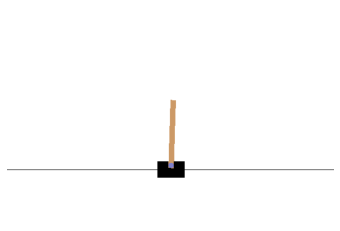

episode: 9/10, score: 200.0


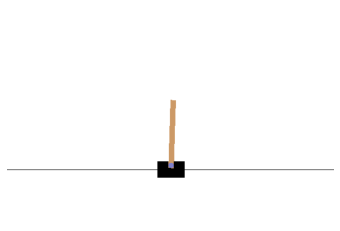

In [15]:
from PIL import Image

#Test the agent that was trained
env_vis=[]
nb_test_episodes = 10
from gym.wrappers import Monitor

for e_test in range(nb_test_episodes):
 
    state = envCartPole.reset()
    img = plt.imshow(envCartPole.render('rgb_array'))

    state = np.reshape(state, [1, nb_states])
    tot_rewards = 0
    for t_test in range(210):
        display.clear_output(wait=True)
        img.set_data(envCartPole.render('rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        # If you want to make a GIF file
        im = Image.fromarray(envCartPole.render('rgb_array'))
        im.save(PATH_TO_ROOT + 'imag_{:04d}_{:04d}.png'.format(e_test,t_test))
        
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nb_states])
        tot_rewards += reward
        state = nstate
        #t_test = limit_time - 1 : CartPole stayed upright
        #done: CartPole fell. 
        if done or t_test == limit_time - 1: 
            rewards.append(tot_rewards)
            epsilons.append(0) #No exploration
            print("episode: {}/{}, score: {}"
                  .format(e_test, nb_test_episodes, tot_rewards))
            break;
        if d:
          envCartPole.reset()
        
    envCartPole.close()

### GIF creation and animation

In [ ]:
anim_file = PATH_TO_ROOT + 'cartPole.gif'
import imageio
import glob


with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(PATH_TO_ROOT + 'imag*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

# to be done 1 time
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

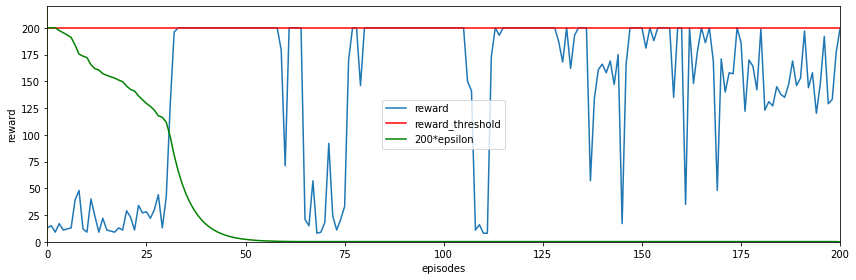

In [ ]:
rolling_average = np.convolve(rewards, np.ones(100)/100)
plt.figure(figsize=(12,4))
plt.plot(rewards,label='reward')
plt.axhline(y=reward_threshold, color='r', linestyle='-',label='reward_threshold') 
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-',label='200*epsilon')

plt.axvline(x=nb_end_training, color='y', linestyle='-')
plt.xlim( (0,nb_episodes) )
plt.xlabel('episodes')
plt.ylim( (0,220) )
plt.ylabel('reward')
plt.legend(loc='best')
plt.tight_layout()


envCartPole.close()

## Experiments  
- change the neural net, the training parameters
- change the discount factor
- reward_threshold and consecutive_wins parameters were only tuned to have a reasobable running time. Try to see what happen woth other values